In [2]:
import os
import neptune
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.python import keras as keras
from keras.models import Model

from sklearn.manifold import Isomap,SpectralEmbedding

from src.results.experiments import _DateExperimentLoader
from src.results.utils import raw_to_xr, dprime
from src.results.neptune import get_model_files, load_models, load_assemblies, load_params, load_properties,prep_assemblies
from src.results.dicarlo import get_dicarlo_su
# from src.data_loader import Shifted_Data_Loader

def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("talk")
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Georgia","Times New Roman", "Palatino", "serif"]
    })

Using TensorFlow backend.


In [3]:
os.environ['NEPTUNE_API_TOKEN']="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5tbCIsImFwaV9rZXkiOiI3ZWExMTlmYS02ZTE2LTQ4ZTktOGMxMi0wMDJiZTljOWYyNDUifQ=="
neptune.init('elijahc/DuplexAE')
neptune.set_project('elijahc/DuplexAE')

Project(elijahc/DuplexAE)

In [4]:
proj_root = '/home/elijahc/projects/vae'

In [5]:
def load_config(exps):
    props = load_properties(exps)
    params = load_params(exps)
    ids = [e.id for e in exps]
    for eid,pr,pa in zip(ids,props,params):
        out = {'id':eid}
        out.update(pr)
        out.update(pa)
        out['exp_dir']=os.path.join(proj_root,pr['dir'])
        yield out

In [6]:
conv_eids = [
    'DPX-29',
    'DPX-30',
]
dense_eids = [
    'DPX-10',
    'DPX-27',
    'DPX-16',

]
conv_exps = neptune.project.get_experiments(id=conv_eids)
dense_exps = neptune.project.get_experiments(id=dense_eids)
exps = np.array(conv_exps+dense_exps)
s_df = pd.DataFrame(list(load_config(exps)))
s_df.head()

,assembly_fn,augmentation,batch_sz,bg,bg_contrast,dataset,dir,encoder_arch,exp_dir,generator_arch,id,im_translation,n_epochs,recon_weight,su_selectivity_fn,xent_weight,y_dim,z_dim
0,NaN,dynamic,512.0,natural,0.3,fashion_mnist,models/2019-11-04/DPX-29,convnet,/home/elijahc/projects/vae/models/2019-11-04/D...,resnet,DPX-29,0.75,54000.0,0.0,NaN,15.0,35,35
1,NaN,dynamic,512.0,natural,0.3,fashion_mnist,models/2019-11-04/DPX-30,convnet,/home/elijahc/projects/vae/models/2019-11-04/D...,resnet,DPX-30,0.75,54000.0,1.0,NaN,15.0,35,35
2,dataset.nc,dynamic,512.0,natural,0.3,fashion_mnist,models/2019-09-25/DPX-10,dense,/home/elijahc/projects/vae/models/2019-09-25/D...,resnet,DPX-10,0.75,54000.0,1.0,selectivity.pqt,15.0,35,35
3,NaN,dynamic,512.0,natural,0.3,fashion_mnist,models/2019-09-25/DPX-16,dense,/home/elijahc/projects/vae/models/2019-09-25/D...,resnet,DPX-16,0.75,54000.0,0.0,NaN,15.0,35,35
4,NaN,dynamic,512.0,natural,0.3,fashion_mnist,models/2019-09-25/DPX-27,dense,/home/elijahc/projects/vae/models/2019-09-25/D...,resnet,DPX-27,0.75,54000.0,1.0,NaN,15.0,35,35


In [7]:
recon_idxs = s_df.query('recon_weight > 0 & encoder_arch == "dense"').index.values

In [8]:
recon_exps = exps[recon_idxs]

In [9]:
mod = next(load_models(proj_root,recon_exps))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


In [10]:
# mod.summary()

In [11]:
mod.get_layer(name='Classifier')

In [12]:
mod.get_layer(name='Encoder').summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 56, 56, 1)    0                                            
__________________________________________________________________________________________________
embedder (Sequential)           (None, 500)          16413500    input_1[0][0]                    
__________________________________________________________________________________________________
y_dim (Dense)                   (None, 35)           17535       embedder[1][0]                   
__________________________________________________________________________________________________
z_dim (Dense)                   (None, 35)           17535       embedder[1][0]                   
__________________________________________________________________________________________________
latent (Co

In [73]:
from src.results.dicarlo import get_dicarlo_su
dicarlo_df = get_dicarlo_su(proj_root,fn='su_selectivity_dicarlo_hi_var.pqt')

In [75]:
dicarlo_df.groupby('region').count()

,neuroid_id,subregion,layer,variation,tx,ty,rxy,object_name,category_name
region,,,,,,,,,
IT,168,168,168,168,168,168,168,168,168
V4,128,128,128,128,128,128,128,128,128
pixel,6553,6553,6553,6553,5110,5110,5110,5110,5110


In [13]:
epochs=5
num_train_samples = 60000
end_step = np.ceil(1.0 * num_train_samples / 512).astype(np.int32) * epochs
print(end_step)
new_pruning_params = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50,
                                                   final_sparsity=0.90,
                                                   begin_step=0,
                                                   end_step=end_step,
                                                   frequency=100)
}

# new_pruned_model = sparsity.prune_low_magnitude(mod.layers[1], **new_pruning_params)
# new_pruned_model.compile(
#     loss=tf.keras.losses.categorical_crossentropy,
#     optimizer='adam',
#     metrics=['accuracy'])
# new_pruned_model.summary()

590


NameError: name 'sparsity' is not defined

In [14]:
E = mod.layers[1]
E.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 56, 56, 1)    0                                            
__________________________________________________________________________________________________
embedder (Sequential)           (None, 500)          16413500    input_1[0][0]                    
__________________________________________________________________________________________________
y_dim (Dense)                   (None, 35)           17535       embedder[1][0]                   
__________________________________________________________________________________________________
z_dim (Dense)                   (None, 35)           17535       embedder[1][0]                   
__________________________________________________________________________________________________
latent (Co

In [15]:
lz = E.layers[3]
ly = E.layers[2]

lzk = lz.get_weights()[0]
lyk = lz.get_weights()[0]
lzk.shape

(500, 35)

In [16]:
lat_k = np.concatenate([np.abs(lzk),np.abs(lyk)],axis=0)

In [17]:
# zisok = Isomap(n_neighbors=5,n_jobs=5)
# yisok = Isomap(n_neighbors=5,n_jobs=5)
isok = Isomap(n_neighbors=5,n_jobs=5)
kout = isok.fit_transform(lat_k)
# zk_out = zisok.fit_transform(lzk)
# yk_out = yisok.fit_transform(lyk)

In [18]:
kout.shape

(1000, 2)

In [19]:
kdf = pd.DataFrame(kout,columns=['dim1','dim2'])
# kout['target']

In [20]:
zk = kdf.iloc[:500]
yk = kdf.iloc[500:]

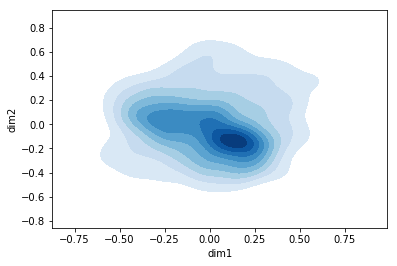

In [21]:
ax = sns.kdeplot(zk.dim1,zk.dim2,shade=True,shade_lowest=False,cmap='Blues')
# ax.scatter(yk.dim1.values,yk.dim2.values,marker='+',c='white',s=3)
# ax = sns.kdeplot(yk.dim1,yk.dim2,shade=True,shade_lowest=False,cmap='Reds')

In [22]:
# sns.kdeplot(zk_out[:,0],zk_out[:,1])

In [23]:
# sns.kdeplot(yk_out[:,0],yk_out[:,1])

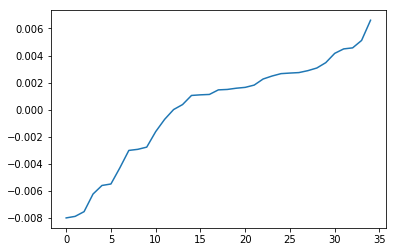

In [24]:
plt.plot(sorted(lzk.mean(axis=0)))

(array([  93.,  890., 2437., 3037., 3153., 3007., 2826., 1679.,  350.,
          28.]),
 array([-0.16401076, -0.12942164, -0.09483251, -0.06024338, -0.02565425,
         0.00893488,  0.043524  ,  0.07811313,  0.11270227,  0.14729139,
         0.18188052], dtype=float32),
 <a list of 10 Patch objects>)

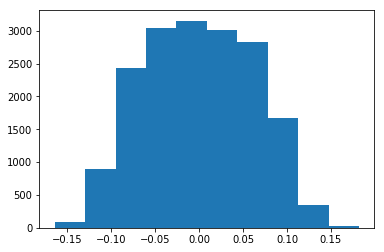

In [25]:
plt.hist(lz.get_weights()[0].flatten())

In [26]:
das = load_assemblies(proj_root,recon_exps)

In [27]:
da = next(das)

In [28]:
np.unique(da.region.values)

array(['dense_3', 'pixel', 'y_lat', 'z_lat'], dtype=object)

In [29]:
z_enc = da.sel(region='z_lat').values
y_enc = da.sel(region='y_lat').values

In [30]:
edir = s_df.query("id == 'DPX-10'").exp_dir.values[0]

In [31]:
su_df = pd.read_parquet(os.path.join(edir,'su_selectivity.pqt'))
su_df = su_df.rename(columns={'category':'category_name'})

In [32]:
sns.set_context('talk')

In [33]:
su_y = su_df.query('region == "y_lat"')
su_z = su_df.query('region == "z_lat"')

In [34]:
su_y.query('ty > 0.18 | tx > 0.18').head()

,layer,region,tx,ty,category_name
5637,4,y_lat,0.281075,0.338167,0.888187
5638,4,y_lat,0.407650,0.079740,0.398935
5640,4,y_lat,0.189315,0.101221,1.000000
5641,4,y_lat,0.265090,0.173134,0.932952
5642,4,y_lat,0.264453,0.264198,0.656403


In [35]:
dicarlo_df = get_dicarlo_su(proj_root,fn='su_selectivity_dicarlo_hi_var.pqt')
dicarlo_df = dicarlo_df.fillna(0).query('region != "pixel"')

from src.results.dicarlo import err_neuroids
dicarlo_df = dicarlo_df[~dicarlo_df.neuroid_id.isin(err_neuroids)]

In [36]:
def mk_pairplot(df,select_vars=['tx','category_name','ty'],offdiag_lim=None,**kw_args):
    
    g = sns.pairplot(vars=select_vars,data=df,**kw_args)
    
    return g

In [37]:
def clear_then_plot(func):
    def func_wrapper(*args,**kwargs):
        plt.cla()
        func(*args,**kwargs)
    return func_wrapper

def set_xymax(x,y,color,label,xylim,**kwargs):
            plt.gca().set_xlim(*xylim)
            plt.gca().set_ylim(*xylim)

def null(*args,**kwargs):
    pass

/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'marker'
  s)


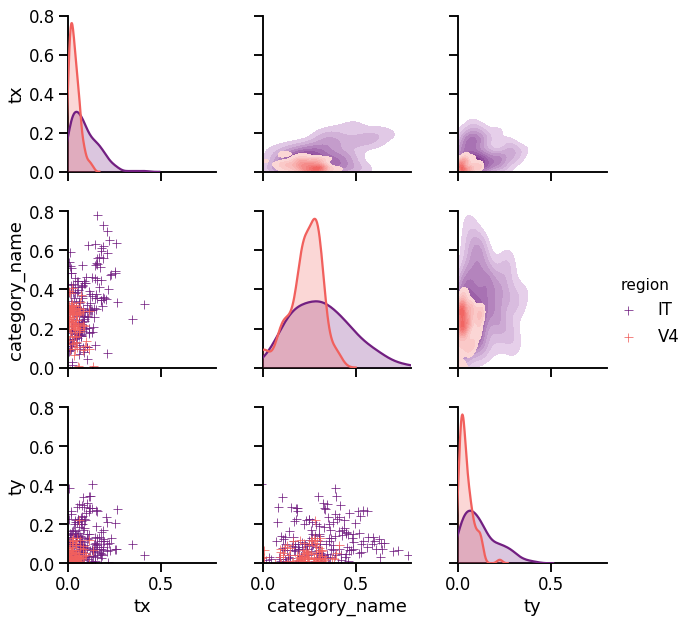

In [38]:
# sns.set_context('talk')
sns.set_context('talk')
offdiag_lim=(0,0.8)
# g = mk_pairplot(dicarlo_df.query('region == "IT"'), kind='scatter',height=2,markers='+')
g = mk_pairplot(dicarlo_df, kind='scatter',hue='region',height=3,markers='+',palette='magma')
# g.map_upper(clear_then_plot(sns.kdeplot),shade=True,shade_lowest=False)
g.map_upper(clear_then_plot(null))
g.map_upper(sns.kdeplot,shade=True,shade_lowest=False)

g.map_diag(lambda *args,xlim,**kwargs: plt.gca().set_xlim(*xlim),xlim=offdiag_lim)
g.map_offdiag(set_xymax,xylim=offdiag_lim)
# g.fig.set_tight_layout(tight=True)
# g.map_diag(clear_then_plot())

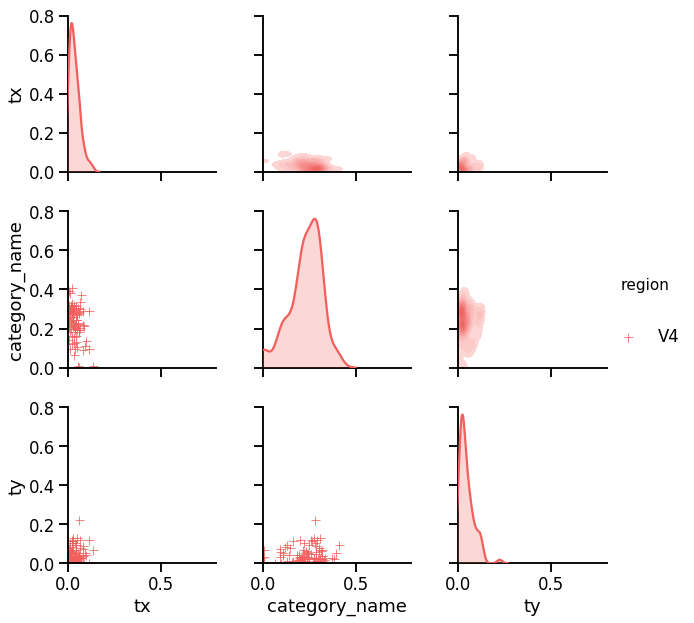

In [39]:
sns.set_context('talk')
offdiag_lim=(0,0.8)
g = mk_pairplot(dicarlo_df, kind='scatter',hue='region',height=3,markers='+',palette='magma',hue_order=['','V4'])
g.map_upper(clear_then_plot(sns.kdeplot),shade=True,shade_lowest=False)

g.map_diag(lambda *args,xlim,**kwargs: plt.gca().set_xlim(*xlim),xlim=offdiag_lim)
g.map_offdiag(set_xymax,xylim=offdiag_lim)
# g.fig.set_tight_layout(tight=True)

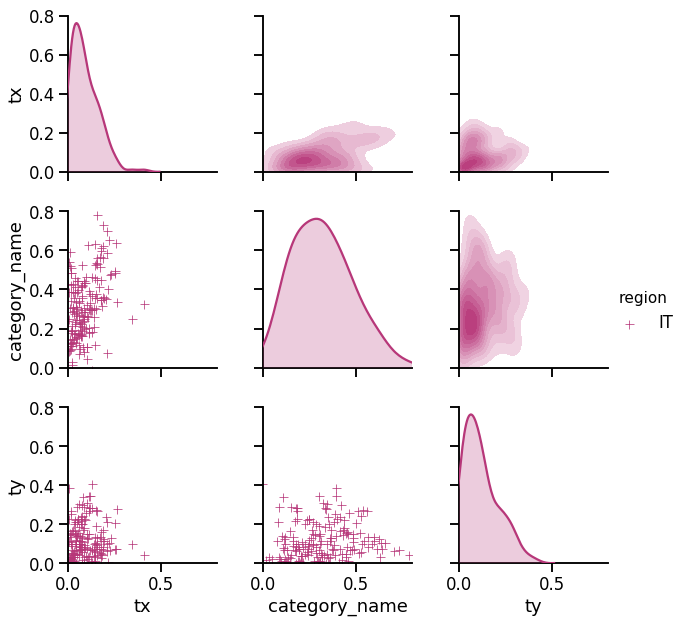

In [40]:
sns.set_context('talk')
offdiag_lim=(0,0.8)
g = mk_pairplot(dicarlo_df, kind='scatter',hue='region',height=3,markers='+',palette='magma',hue_order=['IT'])
g.map_upper(clear_then_plot(sns.kdeplot),shade=True,shade_lowest=False)

g.map_diag(lambda *args,xlim,**kwargs: plt.gca().set_xlim(*xlim),xlim=offdiag_lim)
g.map_offdiag(set_xymax,xylim=offdiag_lim)
# g.fig.set_tight_layout(tight=True)

In [41]:
su_df.groupby('region').count()

,layer,tx,ty,category_name
region,,,,
dense_2,2000,2000,2000,2000
dense_3,500,500,500,500
pixel,3136,3136,3136,3136
y_lat,35,35,35,35
z_lat,35,35,35,35


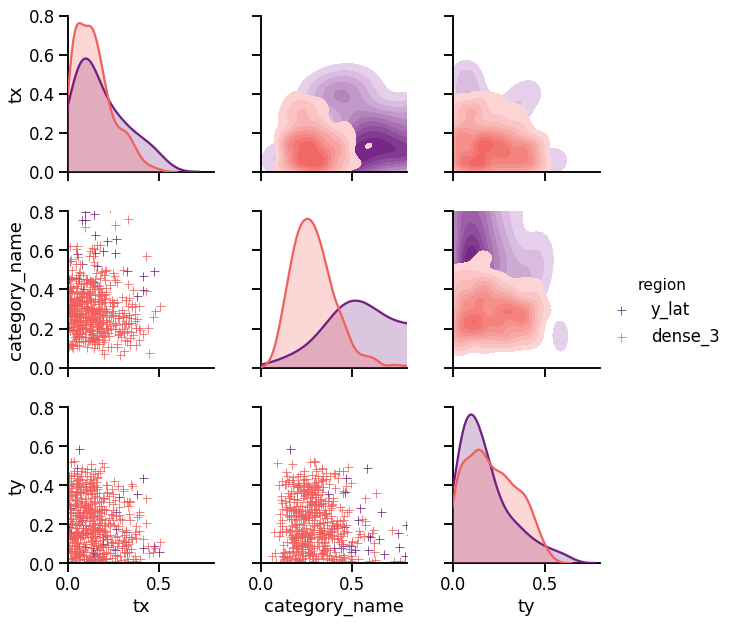

In [42]:
sns.set_context('talk')
offdiag_lim=(0,0.8)
# g = mk_pairplot(dicarlo_df.query('region == "IT"'), kind='scatter',height=2,markers='+')
g = mk_pairplot(su_df, kind='scatter',hue='region',height=3,markers='+',palette='magma',hue_order=['y_lat','dense_3'])
# g.map_upper(clear_then_plot(sns.kdeplot),shade=True,shade_lowest=False)
g.map_upper(clear_then_plot(null))
g.map_upper(sns.kdeplot,shade=True,shade_lowest=False)

g.map_diag(lambda *args,xlim,**kwargs: plt.gca().set_xlim(*xlim),xlim=offdiag_lim)
g.map_offdiag(set_xymax,xylim=offdiag_lim)

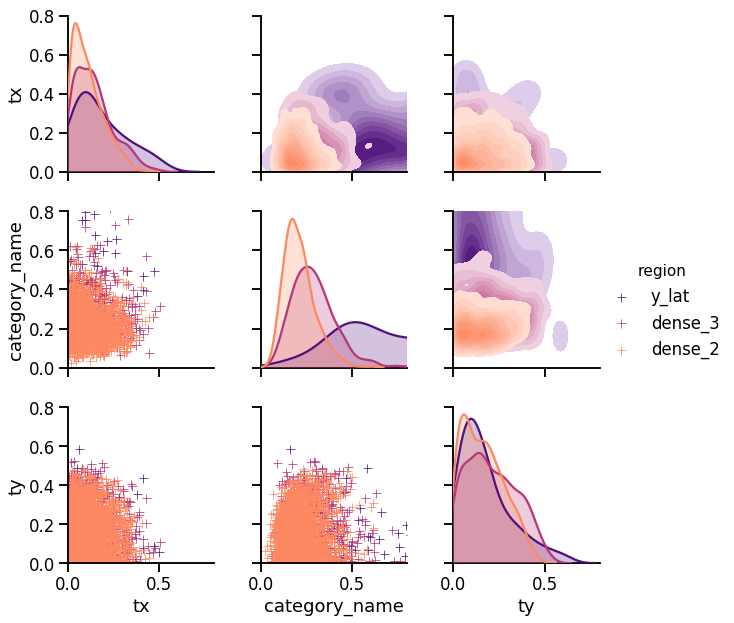

In [43]:
sns.set_context('talk')
offdiag_lim=(0,0.8)
# g = mk_pairplot(dicarlo_df.query('region == "IT"'), kind='scatter',height=2,markers='+')
g = mk_pairplot(su_df, kind='scatter',hue='region',height=3,markers='+',palette='magma',hue_order=['y_lat','dense_3','dense_2'])
# g.map_upper(clear_then_plot(sns.kdeplot),shade=True,shade_lowest=False)
g.map_upper(clear_then_plot(null))
g.map_upper(sns.kdeplot,shade=True,shade_lowest=False)

g.map_diag(lambda *args,xlim,**kwargs: plt.gca().set_xlim(*xlim),xlim=offdiag_lim)
g.map_offdiag(set_xymax,xylim=offdiag_lim)

In [44]:
no_recon = neptune.project.get_experiments(id=['DPX-16','DPX-29'])

In [45]:
edir = exps[1].get_properties()['dir']
su_no_recon_df = pd.read_parquet(os.path.join(proj_root,edir,'su_selectivity_1.pqt'))

In [46]:
su_no_recon_df.groupby('region').count()

,layer,tx,ty,category
region,,,,
conv_1,192,192,192,192
conv_2,192,192,192,192
conv_3,192,192,192,192
conv_4,192,192,192,192
pixel,3136,3136,3136,3136
y_enc,35,35,35,35
z_enc,35,35,35,35


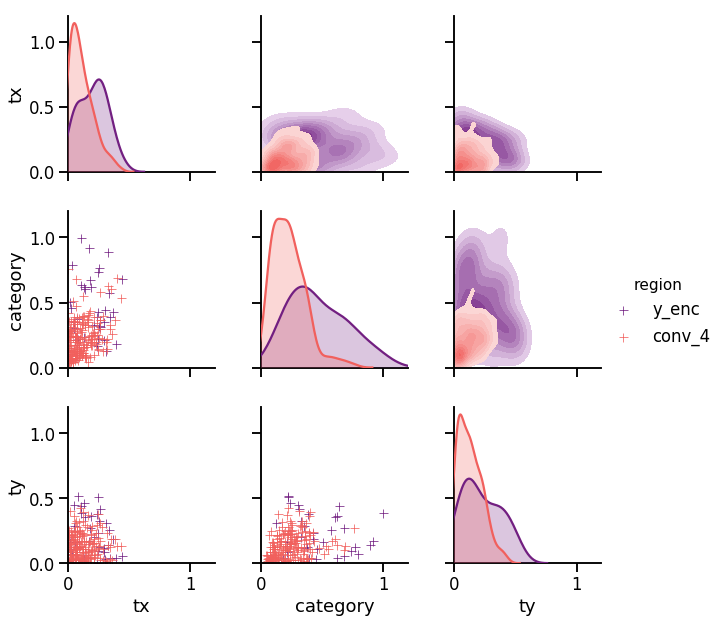

In [47]:
sns.set_context('talk')

# g = mk_pairplot(dicarlo_df.query('region == "IT"'), kind='scatter',height=2,markers='+')
g = mk_pairplot(su_no_recon_df, select_vars=['tx','category','ty'],kind='scatter',hue='region',height=3,markers='+',palette='magma',
                hue_order=['y_enc','conv_4'],
               )
# g.map_upper(clear_then_plot(sns.kdeplot),shade=True,shade_lowest=False)
g.map_upper(clear_then_plot(null))
g.map_upper(sns.kdeplot,shade=True,shade_lowest=False)

offdiag_lim=(0,1.2)
g.map_diag(lambda *args,xlim,**kwargs: plt.gca().set_xlim(*xlim),xlim=offdiag_lim)
g.map_offdiag(set_xymax,xylim=offdiag_lim)

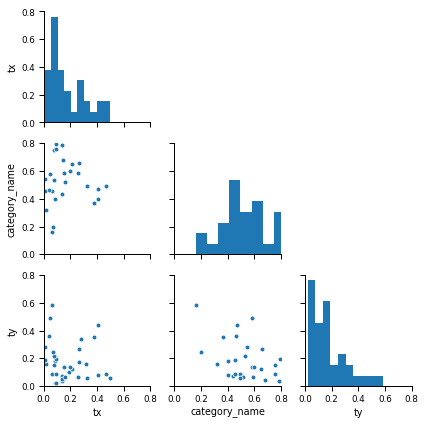

In [48]:
select_vars = ['tx','category_name','ty']

sns.set_context('paper')

g = sns.pairplot(vars=select_vars,data=su_y,kind='scatter',height=2,
#                  diag_kind='kde',diag_kws={'bw':0.15}
                 diag_kind='hist',diag_kws={'bins':10},
                )

for ax in g.axes.ravel():
    ax.set_xlim(0,0.8)
    ax.set_ylim(0,0.8)

off_diag = np.concatenate([g.axes[0,1:],g.axes[1,2:]])
for ax in off_diag:
    ax.set_visible(False)

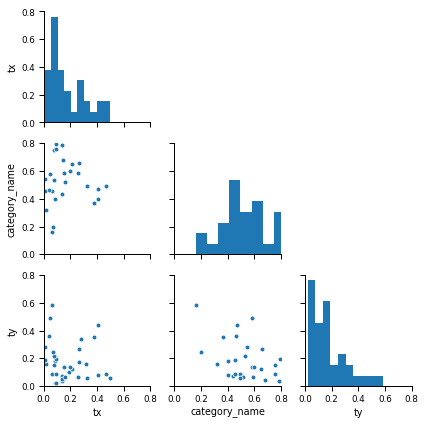

In [49]:
select_vars = ['tx','category_name','ty']

sns.set_context('paper')

g = sns.pairplot(vars=select_vars,data=su_y,kind='scatter',height=2,
#                  diag_kind='kde',diag_kws={'bw':0.15}
                 diag_kind='hist',diag_kws={'bins':10},
                )

for ax in g.axes.ravel():
    ax.set_xlim(0,0.8)
    ax.set_ylim(0,0.8)

off_diag = np.concatenate([g.axes[0,1:],g.axes[1,2:]])
for ax in off_diag:
    ax.set_visible(False)

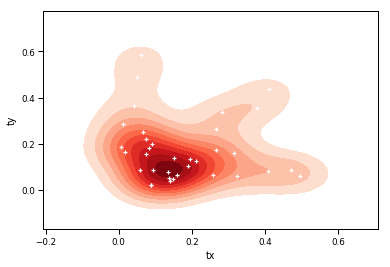

In [50]:
ax = sns.kdeplot(su_y.tx,su_y.ty,shade=True,shade_lowest=False,cmap='Reds')
ax.scatter(su_y.tx,su_y.ty,c='white',marker='+')

In [51]:
sns.distplot(su_y.category,bins=10,rug=True,kde_kws={'bw':0.25,'shade':True,})

AttributeError: 'DataFrame' object has no attribute 'category'

In [55]:
su_y.describe()

,layer,tx,ty,category_name
count,35.0,35.000000,35.000000,35.000000
mean,4.0,0.178278,0.175345,0.617115
std,0.0,0.136385,0.139367,0.227324
min,4.0,0.006679,0.020739,0.159796
25%,4.0,0.075036,0.070890,0.457006
50%,4.0,0.139802,0.138498,0.586087
75%,4.0,0.264771,0.234051,0.790998
max,4.0,0.496383,0.586570,1.000000


In [56]:
plt.hist(.tx)
plt.hist(su_df.query('region == "y_lat"').ty)

SyntaxError: invalid syntax (<ipython-input-56-3d436025e649>, line 1)

In [57]:
dx = da.dx.values
dy = da.dy.values

In [58]:
z_enc.shape

(10000, 35)

In [59]:
ziso = Isomap(n_neighbors=10, n_jobs=5)
yiso = Isomap(n_neighbors=10, n_jobs=5)

In [60]:
z_out = ziso.fit_transform(z_enc)

In [61]:
y_out = yiso.fit_transform(y_enc)

In [62]:
out = np.concatenate([z_out,y_out],axis=1)

In [63]:
out.shape

(10000, 4)

In [64]:
iso_df = pd.DataFrame(out,columns=['z_dim1','z_dim2','y_dim1','y_dim2'])

In [65]:
iso_df['dx'] = dx
iso_df['dy'] = dy
iso_df['tx'] = da.tx.values
iso_df['ty'] = da.ty.values

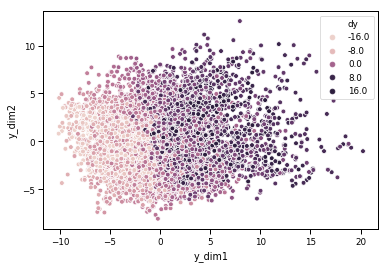

In [69]:
sns.set_context('paper')
sns.scatterplot(x='y_dim1',y='y_dim2',hue='dy',data=iso_df)

In [ ]:
zd1 = iso_df.z_dim1
zd2 = iso_df.z_dim2


Z1,Z2 = np.meshgrid(zd1,zd2)

In [ ]:
sns.lmplot(x='dx',y='y_dim1',data=iso_df,)